In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from skimage import transform

In [59]:
model1 = keras.models.load_model('C:/Users/User/Downloads/models for char ocr/3/best of the best/best_model 7.h5')
model2 = keras.models.load_model('C:/Users/User/Downloads/models for char ocr/3/best of the best/best_model 8.h5')
model3 = keras.models.load_model('C:/Users/User/Downloads/models for char ocr/3/best of the best/best_model 9.h5')

In [5]:
class_indices = {0: 'א',
                 1: 'ע',
                 2: 'ב',
                 3: 'צ',
                 4: 'ץ',
                 5: 'כ',
                 6: 'ך',
                 7: 'ח',
                 8: 'ד',
                 9: 'ג',
                 10: 'ה',
                 11: 'ק',
                 12: 'ל',
                 13: 'מ',
                 14: 'ם',
                 15: 'נ',
                 16: 'ו',
                 17: 'פ',
                 18: 'ף',
                 19: 'ר',
                 20: 'ס',
                 21: 'ש',
                 22: 'ת',
                 23: 'ט',
                 24: 'ו',
                 25: 'י',
                 26: 'ז'}

class_reverse = {v: k for k, v in class_indices.items()}
ends_letters = 'ןםףךץ'

In [6]:
def threshold_low_heigh(img_gray):
    mid_color = np.median(img_gray)
    low = int(max(0, 0.7 * mid_color))
    high = int(min(255, 1.3 * mid_color))
    return low, high

In [7]:
import scipy.ndimage

def correct_skew(gray, delta=1, limit=5):
    def determine_score(arr, angle):
        data = scipy.ndimage.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [8]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
        
    if width is not None and height is not None:
        dim = (width, height)
    elif width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
        
    return cv2.resize(image, dim, interpolation = inter)

In [9]:
def remove_shadow(gray):
    dilated_img = cv2.dilate(gray, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img.copy(), 21)
    diff_img = 255 - cv2.absdiff(gray, bg_img)
    norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    work_img = cv2.threshold(norm_img, 0, 255, cv2.THRESH_OTSU)[1]
    return work_img

In [10]:
def remove_lines(gray_img, way ='vertical'):
    img_h, img_w = gray_img.shape[:2]
    k_size = img_h//20
    kernel_size = (1, k_size)
    
    if way == 'horzintal':
        k_size = img_w//20
        kernel_size = (k_size, 1)
        
    thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(gray_img, [c], -1, 255, 2)

    return gray_img

In [22]:
def sort_contours_word(cnts):
    if len(cnts) == 0:
        return cnts
    boundingBoxes = [list(cv2.boundingRect(c)) for c in cnts]
    # sort by y value 
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b: b[1][1]))
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b: -(b[1][0] +b[1][2])))
    return cnts

In [90]:
def detect_rows(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if np.median(image) < 50:
        image = cv2.bitwise_not(image)
        
    image = remove_shadow(image)
    
    
    low, high = threshold_low_heigh(image)
    
    img_h, img_w = image.shape[:2]
    blur_k_h = max(img_h//70 + ((img_h//70) % 2 == 0),1)
    blur_k_w = max(img_w//70 + ((img_w//70) % 2 == 0),1)
    blur = cv2.GaussianBlur(image.copy(), (blur_k_w, blur_k_h), 0)
    
    thresh = cv2.threshold(blur, low, high, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    img_w-=5
    thresh = thresh[:img_h,5:img_w]
    image = image[:img_h,5:img_w]
    img_w-=5
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(img_w//7, 1))
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    black = np.zeros_like(image)
    list_roi = []
    min_h = img_h//50
    min_w = img_w//10
    min_area = (min_w + 1) * (min_h + 1)
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if  w > min_w and h > min_h and cv2.contourArea(c) > min_area:
            convexHull = cv2.convexHull(c)
            w_min, h_min = convexHull.min(axis=0)[0]
            
            w_max, h_max = convexHull.max(axis=0)[0]
            
            img2 = image.copy()
            black2 = black.copy()
            cv2.drawContours(black2, [convexHull],-1, 255, -1)
            black2 = cv2.threshold(black2, low, high, cv2.THRESH_BINARY)[1]
            img2 = cv2.bitwise_not(img2)
            masked = cv2.bitwise_and(img2, img2, mask = black2)
            masked = cv2.bitwise_not(masked)
            list_roi.append(masked[h_min:h_max, w_min:w_max])
        
    list_roi.reverse()
    return list_roi

In [40]:
def detect_words(image):
    image = image_resize(image, width=1000)
    blur_gray = cv2.GaussianBlur(image.copy(), (11,11), 0)
    low, high = threshold_low_heigh(image) 
    thresh = cv2.threshold(blur_gray, low, high, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    edges = cv2.Canny(thresh, low, high)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,15))
    dilate = cv2.dilate(edges, kernel, iterations=3)
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sort_contours_word(cnts)
    
    black = np.zeros_like(image)
    list_words = []
    min_h = image.shape[0]//100
    min_w = image.shape[1]//100
    min_area = (min_h + 1)*(min_w + 1)
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if cv2.contourArea(c) > min_area and w > min_w and h > min_h:
            convexHull = cv2.convexHull(c)
            w_min, h_min = convexHull.min(axis=0)[0]
            
            w_max, h_max = convexHull.max(axis=0)[0]
            
            img2 = image.copy()
            black2 = black.copy()
            cv2.drawContours(black2, [convexHull],-1, 255, -1)
            black2 = cv2.threshold(black2, low, high, cv2.THRESH_BINARY)[1]
            img2 = cv2.bitwise_not(img2)
            masked = cv2.bitwise_and(img2, img2, mask = black2)
            masked = cv2.bitwise_not(masked)
            list_words.append(masked[h_min:h_max, w_min:w_max])
    return list_words

In [14]:
def pre_process_image(img):
    (tH, tW) = img.shape
    if tW > tH:
        img = image_resize(img, width=40, inter=cv2.INTER_AREA)
    else:
        img = image_resize(img, height=40, inter=cv2.INTER_AREA)
    (tH, tW) = img.shape 
    dX = int(max(0, 40 - tW) / 2.0)
    dY = int(max(0, 40 - tH) / 2.0)
    padded = cv2.copyMakeBorder(img, top=dY, bottom=dY,left=dX,
                                right=dX, borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
    padded = cv2.resize(padded, (40, 40),interpolation = cv2.INTER_AREA)
    return padded

In [70]:
def sort_contours_letters(cnts):
    boundingBoxes = [cv2.boundingRect(c)for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b: -(b[1][0] + b[1][2]/1.2)))
    return cnts

In [16]:
def find_letters_size(list_rows):
    letters_hight, number_letters = 0.0, 0.1
    for row in list_rows:
        list_words = detect_words(row)
        for word in list_words:
            blur_gray = cv2.GaussianBlur(word.copy(), (5, 5), 0)
            low, high = threshold_low_heigh(word) 
            thresh = cv2.threshold(blur_gray, low, high, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            edges = cv2.Canny(thresh, low, high)
            kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,2))
            dilate = cv2.dilate(edges, kernel, iterations=1)
            cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]
            img_h = word.shape[0]
            img_w = word.shape[1]
            min_h = max(img_h//10, 1)
            min_w = max(img_w//45, 1)
            min_area = (min_h + 1)*(min_w + 1)
            for c in cnts:
                _,_,_,h = cv2.boundingRect(c)
                convexHull = cv2.convexHull(c)
                w_min, h_min = convexHull.min(axis=0)[0]
                w_max, h_max = convexHull.max(axis=0)[0]
                h = (h_max-h_min)/(img_h*1.0)
                letters_hight += h
                number_letters +=1.0
    return letters_hight/number_letters

In [82]:
def detect_letters(image):
    blur_gray = cv2.GaussianBlur(image.copy(), (7, 7), 0)
    low, high = threshold_low_heigh(image) 
    thresh = cv2.threshold(blur_gray, low, high, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    edges = cv2.Canny(thresh, low, high)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,6))
    dilate = cv2.dilate(edges, kernel, iterations=1)
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sort_contours_letters(cnts)
    
    black = np.zeros_like(image)
    list_latters = []
    img_h = image.shape[0]
    min_h = max(img_h//45,1)
    min_w = max(image.shape[1]//100,1)
    min_area = (min_h + 1)*(min_w + 1)
    list_loc = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if cv2.contourArea(c) > min_area and w > min_w and h > min_h:
            convexHull = cv2.convexHull(c)
            w_min, h_min = convexHull.min(axis=0)[0]
            
            w_max, h_max = convexHull.max(axis=0)[0]
            
            img2 = image.copy()
            black2 = black.copy()
            cv2.drawContours(black2, [convexHull],-1, 255, -1)
            black2 = cv2.threshold(black2, low, high, cv2.THRESH_BINARY)[1]
            img2 = cv2.bitwise_not(img2)
            masked = cv2.bitwise_and(img2, img2, mask = black2)
            res = masked[h_min:h_max, w_min:w_max]
            res = pre_process_image(res)
            np_image = np.array(res).astype('float32')/255
            np_image = transform.resize(np_image, (40, 40,1))
            np_image = (np.expand_dims(np_image, 0))
            list_latters.append(np_image)
            list_loc.append((x,y,w,(h_max-h_min)/(img_h*1.0)))
    return list_latters ,list_loc

In [18]:
def predict_word(letters, model):
    preds = model.predict(np.vstack(letters),verbose = 0)
    s =''
    for i in range(len(preds)):
        #max_val = np.max(preds[i])
        x = class_indices[np.argmax(preds[i])]
        if i < len(preds)-1:
            j = -1
            while x in ends_letters:
                x = class_indices[np.argpartition(preds[i],j)[j]]
                j-=1
        s+= x
    return s

In [19]:
def getMaxOccurringChar(s):
    count = [0] * 27
    for c in s:
        count[class_reverse[c]]+=1
    val = (max(count))
    res = class_indices[count.index(val)]
    return res

In [78]:
def correct_word(s, locations, avg_letter_hight):
    size = len(s)-1
    i = 0   
    while i < size:
        if s[i] == 'ו' and locations[i][-1] < avg_letter_hight *0.7:
            s = s[:i] +'י'+ s[i+1:]
        if s[i] == 'י' and locations[i][-1] > avg_letter_hight *0.8:
            s = s[:i] +'ו'+ s[i+1:]
        i = i +1
        
    if s[size] in 'יון':
        if locations[size][-1] > avg_letter_hight *0.8:
            if locations[size][-1] > avg_letter_hight *1.2:
                s = s[:size] +'ן'
            elif s[size] == 'י' or  locations[size][-1] < avg_letter_hight:
                s = s[:size] +'ו'
                
        elif locations[size][-1] < avg_letter_hight *0.7 or s[size] == 'ן':
            s = s[:size] +'י'
    
    i = 0
    while i < size:
        if s[i] in "רה" :
            x1,y1,w1,h1 = locations[i]
            x2,y2,w2,h2 = locations[i+1]
            if x1 <= x2 + w2+2 and y1 < y2:
                if s[i+1] in 'יחר':
                    s = s[:i] + 'ה' + s[i+2:]
                    size = size -1
                    del locations[i+1]
                elif s[i+1] in 'ון':
                    s = s[:i] + 'ק' + s[i+2:]
                    size = size -1
                    del locations[i+1]
        elif s[i] in 'א' and s[i+1] in 'רון':
            x1,y1,w1,h1 = locations[i]
            x2,y2,w2,h2 = locations[i+1]
            if x1 < x2 + w2 +5:
                s = s[:i] + 'א' + s[i+2:]
                size = size -1 
                del locations[i+1]
        i = i+1
    return s

In [60]:
def predict_word_per_model(letters, locations, avg_letter_hight):
    s1 = predict_word(letters, model1)
    s2 = predict_word(letters, model2)
    s3 = predict_word(letters, model3)
    s = ''
    for i in range(len(s1)):
        c1, c2, c3 = s1[i], s2[i], s3[i]
        if c1 == c2:
            s = s[:i] + c1
        elif c2 == c3:
            s = s[:i] + c2
        else:
            s = s[:i] + c1
    return correct_word(s, locations, avg_letter_hight)

In [29]:
image = cv2.imread('C:/Users/User/OneDrive/Pictures/heb handwritten/4.jpeg')
save_location = "C:/Users/User/OneDrive/Pictures/heb letters/lettersss"
end_image = '.jpeg'
i = 2600
list_roi = detect_rows(image)
for row in list_roi:
    list_words = detect_words(row)
    for word in list_words:
        list_letters = detect_letters(word,0,0)
        for letter in list_letters:
            image_path = save_location + str(i) + end_image
            cv2.imwrite(image_path, letter)
            i += 1

In [92]:
image = cv2.imread('C:/Users/User/OneDrive/Pictures/heb handwritten/7.jpeg')
result = ''
list_row = detect_rows(image)
avg_letter_h = find_letters_size(list_row)
for row in list_row:
    list_words = detect_words(row)
    for word in list_words:
        list_letters, letters_loc = detect_letters(word)
        if len(list_letters) != 0:
            result += predict_word_per_model(list_letters,letters_loc, avg_letter_h)
            result+=' '
    result+='\n'

print(result)

ייוהמשכילים יזרירו כזהר הרקיעיי 
ק סט כ מ ק 
ראיתי את חיכורין הנפלאיש וגל 
שמעתי אות דרשותין של פה המפיק 
מוגליות בתורת החן 
הנחכם השלו רבנן משהי חוים ארמוני שלוקיא 
כמובן שהמחבר שליודא אינו צרוי להסכמתי 
אכל אין מסרבין לגדול ולקייש רצון צפיק 
ב אתי בהסכ מתו ג 
ונזכה בקרוב להקמת שכונתא מעפרא אומוי 



In [88]:
f = open("output_file.txt", "w", encoding='utf-8')
f.write(result)
f.close()

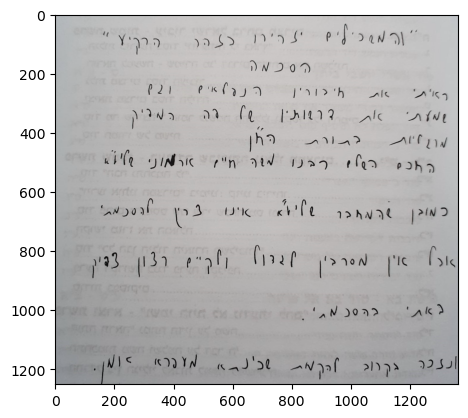

In [84]:
image = cv2.imread('C:/Users/User/OneDrive/Pictures/heb handwritten/7.jpeg')
plt.imshow(image, cmap='gray');

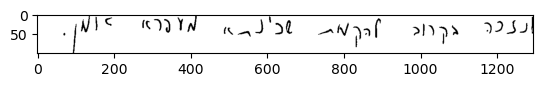

In [81]:
plt.imshow(list_row[-1], cmap='gray');

In [537]:
list_words = detect_words(list_row[0])

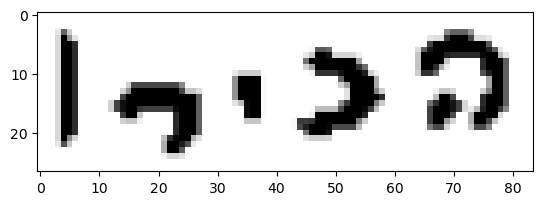

In [538]:
plt.imshow(list_words[0], cmap='gray');

In [27]:
image = cv2.imread('C:/Users/User/OneDrive/Pictures/heb handwritten/heb handwritten 86.jpg')
save_location = "C:/Users/User/OneDrive/Pictures/heb letters/letterss"
end_image = '.jpg'
i = 0
list_roi = detect_rows(image)
for row in list_roi:
    list_words = detect_words(row)
    for word in list_words:
        list_letters = detect_letters(word,0,0)
        for letter in list_letters:
            image_path = save_location + str(i) + end_image
            cv2.imwrite(image_path, letter)
            i += 1

In [45]:
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        img_loc = os.path.join(dir_path, file)
        img  = cv2.imread(img_loc)
        img = cv2.bitwise_not(img)
        cv2.imwrite(img_loc, img)

In [95]:
dir_path = 'C:/Users/User/Downloads/models for char ocr/heb handwritten'
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        image  = cv2.imread(os.path.join(subdir, file))
        image = cv2.bitwise_not(image)
        cv2.imwrite(os.path.join(subdir, file),image)